In [14]:
import collections
from collections import defaultdict
import sys
import json
import random
from jsmin import jsmin
from io import StringIO
import numpy as np
import copy
import importlib
from functools import partial
import math
import os
import argparse

# script_n = os.path.basename(__file__).split('.')[0]
script_n = 'pc_pfs_pattern_similarity_210107_JLR'


sys.path.insert(0, '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc')
import my_plot
importlib.reload(my_plot)
from my_plot import MyPlotData



# ap = argparse.ArgumentParser()
# ap.add_argument("--min_length", type=int, default=20)
# ap.add_argument("--max_dist", type=int, default=100)
# config = ap.parse_args()
min_length = 30
max_dist = 150
n_random = 5


from weight_database import WeightDatabase
weightdb = WeightDatabase()

weightdb.load_syn_db('/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/gen_db/pfs/gen_210101_setup01_syndb_threshold_10_coalesced_filtered_10.gz')
weightdb.load_touch_db(
    '/n/groups/htem/Segmentation/shared-nondev/cb2_segmentation/analysis_mf_grc/purkinje/db_pf_contacts_201224.gz',
    max_dist=max_dist
    )

postsyns = weightdb.get_postsyn_ids()

hist = defaultdict(list)

def calc_pattern_similarity(weightdb, type='Data'):
    mpd = MyPlotData()
    processed = set()
    n = 0
    for pc0 in postsyns:
        for pc1 in postsyns:
            if pc0 == pc1:
                continue
            if (pc0, pc1) in processed:
                continue
            processed.add((pc0, pc1))
            processed.add((pc1, pc0))
            if len(weightdb.get_shared_presyns(pc0, pc1)) < min_length:
                continue
            score = float(weightdb.calc_pattern_similarity(pc0, pc1))
            if math.isnan(score):
                score = 0
            # if score >= 0.7:
            #     print(f'{pc0} and {pc1}: {score}')
            hist[type].append(score)
            mpd.add_data_point(
                score=score,
                type=type,
                )
            n += 1
    print(f'n={n} pairs')
    return mpd

mpd_data = calc_pattern_similarity(weightdb)

weightdb_random = weightdb.randomize_connectivity(type='postsyn')
mpd_random = calc_pattern_similarity(weightdb_random, type='Random')

# print(f'Num samples: {n}')

# import compress_pickle
# compress_pickle.dump(
#     (mpd),
#     f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_db.gz',)

n=650 pairs
n=650 pairs


Height: 4, Aspect: 1.0


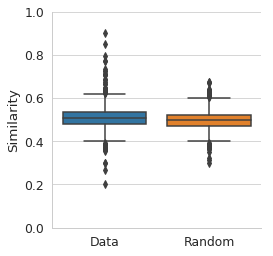

In [15]:
mpd_all = MyPlotData()
mpd_all.append(mpd_data)
mpd_all.append(mpd_random)

importlib.reload(my_plot); my_plot.my_catplot(
    mpd_all,
    x="type",
    y="score",
    # hue="type",
    # hue_order=['All', 'Per PC', 'Per pf'],
    # hue_order=['All', 'Per PC'],
    ylim=[0, 1],
    context='paper',
    kind='box',
    # add_swarm=True,
    # font_scale=1.5,
    height=4,
    width=4,
    y_axis_label='Similarity',
    # x_axis_label='# of synapses per connection',
    save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}.svg',
    show=True,
    )


# importlib.reload(my_plot); my_plot.my_displot(
#     mpd_all,
#     # x="num_syns_per_connection",
#     x="score",
#     hue="type",
#     # hue_order=['All', 'Per PC', 'Per pf'],
#     # hue_order=['All', 'Per PC'],
#     # ylim=[.30, .70],
#     context='paper',
#     kind='hist',
#     # add_swarm=True,
#     # font_scale=1.5,
#     height=4,
#     binwidth=.02,
#     # width=2.5,
#     # y_axis_label='Similarity (%)',
#     x_axis_label='Correlation',
#     save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_dist.svg',
#     show=True,
#     )

In [16]:
import compress_pickle
compress_pickle.dump(
    (mpd_random, mpd_data), 
    f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_n{n_random}_mpd.gz',
    )

Height: 4, Aspect: 1.33


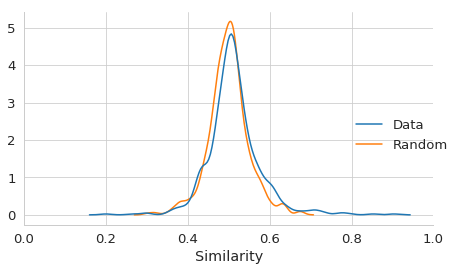

In [17]:


importlib.reload(my_plot); my_plot.my_displot(
    mpd_all,
    # x="num_syns_per_connection",
    x="score",
    hue="type",
    # hue_order=['All', 'Per PC', 'Per pf'],
    # hue_order=['All', 'Per PC'],
#     ylim=[.30, .70],
    xlim=[0, 1],
    context='paper',
    kind='kde',
    # add_swarm=True,
    # font_scale=1.5,
    height=4,
    bw_adjust=.75,
#     binwidth=.02,
    # width=2.5,
    # y_axis_label='Similarity (%)',
    x_axis_label='Similarity',
    save_filename=f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_kde.svg',
    show=True,
    )

In [18]:

hist['Random'] = []
n_random = 5

for i in range(n_random):
    print(i)
    random.seed(i)
    weightdb_random = weightdb.randomize_connectivity(type='postsyn')
    mpd_random = calc_pattern_similarity(weightdb_random, type='Random')

import scipy
fout_name = f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_n{n_random}'
with open(f'{script_n}_results', 'w') as fout:
    for foutt in [fout, sys.stdout]:
        print(scipy.stats.ttest_ind(hist['Data'], hist['Random']), file=foutt)
        print(scipy.stats.ranksums(hist['Data'], hist['Random']), file=foutt)
        print(scipy.stats.mannwhitneyu(hist['Data'], hist['Random'], alternative='greater'), file=foutt)
        print(scipy.stats.ks_2samp(hist['Data'], hist['Random']), file=foutt)


0
n=650 pairs
1
n=650 pairs
2
n=650 pairs
3
n=650 pairs
4
n=650 pairs
Ttest_indResult(statistic=4.02206016761765, pvalue=5.8784167522569755e-05)
RanksumsResult(statistic=3.2271227449788196, pvalue=0.001250418078207376)
MannwhitneyuResult(statistic=1140819.0, pvalue=0.0006250519023788583)
Ks_2sampResult(statistic=0.06923076923076923, pvalue=0.01075431284213868)


In [19]:
import compress_pickle
compress_pickle.dump(
    (hist['Data'], hist['Random']),
    f'{script_n}_max_dist_{max_dist}_min_length_{min_length}_n{n_random}_data.gz'
)